# IMPORTS E CONFIGURAÇÕES

## Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import pickle as pkl
import random
import xgboost as xgb
import seaborn as sns

from IPython.display import Image
from IPython.core.display import HTML

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Configurações

In [2]:
pd.set_option('display.max_columns', None)

def jupyter_settings():
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

# HELPER FUNCIONS

In [3]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
def mean_absolute_percentage_error(y, y_pred):
    # VerifiCa se há divisão por zero
    mask = y != 0
    y, y_pred = np.array(y), np.array(y_pred)
    # Calcule o MAPE apenas para as instâncias onde y não é zero
    return np.mean(np.abs((y[mask] - y_pred[mask]) / y[mask]))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    feats = {
        'Model Name' : model_name,
        'MAE' : mae,
        'MAPE': mape,
        'RMSE': rmse
        }
    return pd.DataFrame(feats, index = [0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    k = 1
    for k in reversed(range(1, kfold+1)):
        
        # dia inicial e final para validação
        validation_start_date = x_training['Date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # separar dados em traino e validação
        training = x_training[x_training['Date'] < validation_start_date]
        validation = x_training[(x_training['Date'] >= validation_start_date) & (x_training['Date'] <= validation_end_date)]

        if verbose:
            print('KFold Number', k)
            print('')
            print('Intervalo')
            print('início', validation_start_date.strftime("%d/%m/%Y"),
                'fim', validation_end_date.strftime("%d/%m/%Y"))
            
            print('total de dias', (validation_end_date - validation_start_date).days,
                'total de semanas', round((validation_end_date - validation_start_date).days / 7))
            print('')
            
            print('Treino')
            print('inicio', training.Date.min().strftime("%d/%m/%Y"),
                'fim', training.Date.max().strftime("%d/%m/%Y"))
            print('dias', (training.Date.max() - training.Date.min()).days,
                'semanas', round((training.Date.max() - training.Date.min()).days / 7))
            print('')
            
            print('Validação')
            print('inicio', validation.Date.min().strftime("%d/%m/%Y"),
                'fim', validation.Date.max().strftime("%d/%m/%Y"))
            print('dias', (validation.Date.max() - validation.Date.min()).days,
                'semanas', round((validation.Date.max() - validation.Date.min()).days / 7))
            print('//')
            
        # dados de treino e validação
        
        # treino
        ytraining = training['Sales']
        xtraining = training.drop(['Date', 'Sales'], axis = 1)
        
        # validação
        yvalidation = validation['Sales']
        xvalidation = validation.drop(['Date', 'Sales'], axis = 1)
        
        # iniciar treino
        m = model.fit(xtraining, ytraining)
        
        # iniciar predição
        yhat = m.predict(xvalidation)
        
        # verificar performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # armazena a performance para cada iteração do kfold
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    dict_result = {
            'Model Name' : model_name,
            'MAE' : np.round(np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
            'MAPE' : np.round(np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
            'RMSE' : np.round(np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
        }
    return pd.DataFrame(dict_result, index=[0])

# LOAD DATA

In [4]:
features_selected = pkl.load( open( "../model/pre-processing/list_features_selected.pkl", "rb" ) )
X_train, X_test, y_train, y_test = pkl.load( open( "../data/transformed/train_test_data.pkl", "rb" ) )

# MODELAGEM

## Separar dados de treino e teste

In [5]:
# Features selecionadas para o modelo
features_selected_droped = [feature for feature in features_selected if feature not in ['Date', 'Sales']]

# Separação entre treino e teste
x_train = X_train[features_selected_droped]
x_test = X_test[features_selected_droped]

# Validação Cruzada
x_train_cv = x_train.copy()
x_train_cv['Date'] = X_train['Date']
x_train_cv['Sales'] = y_train.copy()

# Time Series Data Preparation
x_training = X_train[features_selected]

## Implementar modelos

### Modelos Lineares

#### Simples

##### Modelo de média
> Obs: O principal papel do modelo de média é ser uma base comparativa para performance do outros modelos.

In [6]:
aux1 = x_test.copy()
aux1['Sales'] = y_test.copy()

# average model
aux2 = (
    aux1[['Store', 'Sales']]
    .groupby('Store')
    .mean()
    .reset_index()
    .rename(columns = {'Sales': 'Predictions'})
)
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'Store')
yhat_baseline = aux1['Predictions']

In [ ]:
# performance
baseline_result = ml_error(
    'Modelo de Média', 
    np.expm1(y_test), 
    np.expm1(yhat_baseline)
)
baseline_result.T

,0
Model Name,Modelo de Média
MAE,1354.800353
MAPE,0.2064
RMSE,1835.135542


##### Regressão Linear

In [ ]:
# Iniciar Regressão Linear
lr = (
    LinearRegression()
    .fit(x_train, y_train)
)

# Realizar predição
yhat_1r = lr.predict(x_test)

In [ ]:
# Verificar resultado
lr_result = ml_error(
    'Regressão Linear', 
    np.expm1(y_test), 
    np.expm1(yhat_1r)
)
lr_result.T

,0
Model Name,Regressão Linear
MAE,1867.089774
MAPE,0.292694
RMSE,2671.049215


> Obs: O valor de RMSE do modelo LinearRegression é maior que o RMSE do Modelo de Média, isso indica que os dados tem um comportamento complexo e não lineares, e nesse caso um modelo linear não seria indicado, pois seu erro é maior que o erro de média. Modelos lineares não conseguirão aprender o comportamento desses dados.

##### LASSO: Regressão Linear Regularizado
> Obs: Lasso é o modelo de regressão linear regularizado.

In [ ]:
# Iniciar o modelo Lasso
lrr = (
    Lasso(alpha = 0.01)
    .fit(x_train, y_train)
)

# Realizar a predição
yhat_lrr = lrr.predict(x_test)

In [ ]:
# Verificar resultado
lrr_result = ml_error(
    'Regressão Linear - Lasso', 
    np.expm1(y_test), 
    np.expm1(yhat_lrr)
)
lrr_result.T

,0
Model Name,Regressão Linear - Lasso
MAE,1900.35215
MAPE,0.288484
RMSE,2768.024744


#### Validação Cruzda

##### Validação Cruzada: Regressão Linear

In [ ]:
# Iniciar Validação Cruzada da Regressão Linear
lr_result_cv = cross_validation(
    x_train_cv, 
    5, 
    'Regressão Linear CV', 
    lr
)

In [13]:
lr_result_cv.T

,0
Model Name,Regressão Linear CV
MAE,2081.73 +/- 295.63
MAPE,0.3 +/- 0.02
RMSE,2952.52 +/- 468.37


##### Validação Cruzada: LASSO

In [ ]:
# Iniciar validação cruzada do modelo LASSO
lrr_result_cv = cross_validation(
    x_train_cv, 
    5, 
    'Lasso CV', 
    lrr
)

In [15]:
lrr_result_cv.T

,0
Model Name,Lasso CV
MAE,2128.31 +/- 368.92
MAPE,0.3 +/- 0.01
RMSE,3067.48 +/- 549.4


### Modelos não lineares
> Obs: Esses modelos baseados em árvores foram adaptados para regressão, originalmente foram feitas para classificação.

#### Simples

##### Random Forest Regressor

In [16]:
# Iniciar modelo Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100, 
    n_jobs=-1, 
    random_state=42
)
rf.fit(x_train, y_train)

# Realizar a predição
yhat_rf = rf.predict(x_test)

# Verificar a performance
rf_result = ml_error(
    'Random Forest Regressor', 
    np.expm1(y_test), 
    np.expm1(yhat_rf)
)

In [17]:
rf_result.T

,0
Model Name,Random Forest Regressor
MAE,678.211601
MAPE,0.099792
RMSE,1008.959556


##### XGBoost
> Obs: Utiliza um método que seleciona as variáveis mais relevantes mais rápido e tem uma performace melhor que o modelo de floresta aleatória.

In [18]:
# Iniciar modelp XGBRegressor
# objective -> função objetiva, para o problema de regressão usaremos o reg:squarederror
# eta -> quantas passadas é usada para fazer o aprendizado
# max_depth -> máxima profundidade de ramificações que a árvore pode chegar
# subsample -> quantidade de amostras ou porcentagem de todas as variáveis 
# disponíveis para fazer uma amostragem para selecionar as mais relevantes
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.1,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9
)
model_xgb.fit(x_train, y_train)

# Realizar a predição
yhat_xgb = model_xgb.predict(x_test)

# Verificar performance
xgb_result = ml_error(
    'XGBoost Regressor', 
    np.expm1(y_test), 
    np.expm1(yhat_xgb)
)

In [19]:
xgb_result.T

,0
Model Name,XGBoost Regressor
MAE,819.07702
MAPE,0.119289
RMSE,1204.612453


#### Validação Cruzada

##### Validação Cruzada: Random Forest Regressor

In [20]:
rf_result_cv = cross_validation(
    x_train_cv, 
    5, 
    'Random Forest Regressor CV', 
    rf
)

In [21]:
rf_result_cv.T

,0
Model Name,Random Forest Regressor CV
MAE,840.49 +/- 220.3
MAPE,0.12 +/- 0.02
RMSE,1261.41 +/- 323.58


##### Validação Cruzada: XGBoost

In [22]:
xgb_result_cv = cross_validation(
    x_train_cv, 
    5, 
    'XGBoost Regressor CV', 
    model_xgb
)

In [23]:
xgb_result_cv.T

,0
Model Name,XGBoost Regressor CV
MAE,1010.82 +/- 183.81
MAPE,0.14 +/- 0.02
RMSE,1454.53 +/- 256.66


## Resultado dos Modelos

### Performance Simples

In [24]:
modelling_result = pd.concat(
    [
        baseline_result,
        lr_result,
        lrr_result,
        rf_result,
        xgb_result,
    ]
)
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.211601,0.099792,1008.959556
0,XGBoost Regressor,819.077020,0.119289,1204.612453
0,Modelo de Média,1354.800353,0.206400,1835.135542
0,Regressão Linear,1867.089774,0.292694,2671.049215
0,Regressão Linear - Lasso,1900.352150,0.288484,2768.024744


> O fenômeno que estamos querendo modelar não é um problema simples, por isso os modelos lineares não funcionam muito bem nesses casos.

### Performance Cross Validation

In [25]:
modelling_result_cv = pd.concat(
    [
        lr_result_cv,
        lrr_result_cv,
        rf_result_cv,
        xgb_result_cv
    ]
)
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor CV,840.49 +/- 220.3,0.12 +/- 0.02,1261.41 +/- 323.58
0,XGBoost Regressor CV,1010.82 +/- 183.81,0.14 +/- 0.02,1454.53 +/- 256.66
0,Regressão Linear CV,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso CV,2128.31 +/- 368.92,0.3 +/- 0.01,3067.48 +/- 549.4


> A RandomForest teve um resultado melhor que os demais modelos, e a XGBoot foi o segundo modelo com a melhor performance, mostrando a diferença dos modelos lineares e não lineares. Seguiremos com o modelo XGBoost por exigir custo computacional muito menor que o modelo Ramdon Forest.

# TUNAGEM DE HIPERPARÂMETROS

### Random Search

In [26]:
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03, 0.05, 0.07, 0.1],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
}

max_eval = 5

final_result = pd.DataFrame()

for i in range(max_eval):
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    # param.items(): retorna chave e valor de um dicionário
    # random.sample(v, 1)[0]: pega um (1) valor (v) aleatoriamente da amostra
    # random.sample(v, 1)[0] for k, v in param.items(): valor da chave 'k'
    print('Iteração', i+1, 'de', max_eval)
    print(hp)

    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=hp['n_estimators'], 
        eta=hp['eta'], 
        max_depth=hp['max_depth'], 
        subsample=hp['subsample'],
        colsample_bytree=hp['colsample_bytree'],
        min_child_weight=hp['min_child_weight']
    )

    result = cross_validation(
        x_training, 
        5, 
        'XGBoost Regressor', 
        xgb_model, 
        verbose = True
    )
    final_result = pd.concat([final_result, result])


Iteração 1 de 5
{'n_estimators': 3500, 'eta': 0.07, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
KFold Number 5

Intervalo
início 20/11/2014 fim 01/01/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 19/11/2014
dias 687 semanas 98

Validação
inicio 20/11/2014 fim 01/01/2015
dias 42 semanas 6
//
KFold Number 4

Intervalo
início 01/01/2015 fim 12/02/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 31/12/2014
dias 729 semanas 104

Validação
inicio 01/01/2015 fim 12/02/2015
dias 42 semanas 6
//
KFold Number 3

Intervalo
início 12/02/2015 fim 26/03/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 11/02/2015
dias 771 semanas 110

Validação
inicio 12/02/2015 fim 26/03/2015
dias 42 semanas 6
//
KFold Number 2

Intervalo
início 26/03/2015 fim 07/05/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 25/03/2015
dias 813 semanas 116

Validação
inicio 26/03/2015 fim 07/05/2015

In [27]:
final_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,931.13 +/- 127.92,0.13 +/- 0.01,1332.31 +/- 186.59
0,XGBoost Regressor,856.61 +/- 116.0,0.12 +/- 0.01,1240.22 +/- 186.1
0,XGBoost Regressor,839.85 +/- 140.84,0.12 +/- 0.01,1214.87 +/- 206.61
0,XGBoost Regressor,1559.5 +/- 163.74,0.22 +/- 0.01,2258.57 +/- 226.1
0,XGBoost Regressor,1095.47 +/- 137.16,0.15 +/- 0.01,1567.79 +/- 184.37


### Generalização

In [28]:
# Modelo com os melhores parâmetros obtidos na tunagem
xgb_final = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimators = 2500,
    eta = 0.01,
    max_depth = 9,
    subsample = 0.5,
    colsample_bytree = 0.7,
    min_child_weight = 3,
    nthread = -1
)

# Cross-validation (predição sobre validação após a tunagem)
xgb_result_cv = cross_validation(
    x_training, 
    5, 
    'XGBoost Regressor', 
    xgb_final, 
    verbose = True
)

KFold Number 5

Intervalo
início 20/11/2014 fim 01/01/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 19/11/2014
dias 687 semanas 98

Validação
inicio 20/11/2014 fim 01/01/2015
dias 42 semanas 6
//
KFold Number 4

Intervalo
início 01/01/2015 fim 12/02/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 31/12/2014
dias 729 semanas 104

Validação
inicio 01/01/2015 fim 12/02/2015
dias 42 semanas 6
//
KFold Number 3

Intervalo
início 12/02/2015 fim 26/03/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 11/02/2015
dias 771 semanas 110

Validação
inicio 12/02/2015 fim 26/03/2015
dias 42 semanas 6
//
KFold Number 2

Intervalo
início 26/03/2015 fim 07/05/2015
total de dias 42 total de semanas 6

Treino
inicio 01/01/2013 fim 25/03/2015
dias 813 semanas 116

Validação
inicio 26/03/2015 fim 07/05/2015
dias 42 semanas 6
//
KFold Number 1

Intervalo
início 07/05/2015 fim 18/06/2015
total de dias 42 total de semanas 6

Treino
inicio 01/

In [29]:
xgb_result_cv

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,839.85 +/- 140.84,0.12 +/- 0.01,1214.87 +/- 206.61


In [30]:
# Retreino do modelo com dados de Treino + Validação
xgb_final.fit(x_train, y_train)

# Predição sobre os dados de Teste
yhat_test = xgb_final.predict(x_test)

# Performance final do modelo
error_xgb_final = ml_error(
    'XGBoost Regressor Final', 
    np.expm1(y_test), 
    np.expm1(yhat_test)
)

In [31]:
error_xgb_final

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Final,679.32548,0.099162,995.731145


# TRADUÇÃO DO ERRO

## Performance de Negócio

In [32]:
# Selecionando os dados
df = X_test.loc[:, features_selected_droped].copy()
df.loc[:, 'Sales'] = y_test.copy()

# Removendo a escala logaritmica da variável resposta
df['Vendas'] = np.expm1(df['Sales'])
df['Previsoes'] = np.expm1(yhat_test)

# Soma das previsões
df1 = df[['Store', 'Previsoes']].groupby('Store').sum().reset_index()

# MAE e MAPE
df_aux1 = (
    df[['Store', 'Vendas', 'Previsoes']]
    .groupby('Store')
    .apply(
        lambda x: mean_absolute_error(x['Vendas'], x['Previsoes']), 
        include_groups=False
        )
    .reset_index()
    .rename(columns={0:'MAE'})
)

df_aux2 = (
    df[['Store', 'Vendas', 'Previsoes']]
    .groupby('Store')
    .apply(
        lambda x: mean_absolute_percentage_error(x['Vendas'], x['Previsoes']), 
        include_groups=False
    )
    .reset_index()
    .rename(columns={0:'MAPE'})
)

# Mesclando MAE e MAPE
df_aux3 = pd.merge(df_aux1, df_aux2, how='inner', on='Store')
df2 = pd.merge(df1, df_aux3, how='inner', on='Store')

# Cenários
df2['PiorCenario'] = df2['Previsoes'] - df2['MAE']
df2['MelhorCenario'] = df2['Previsoes'] + df2['MAE']

# Mostrando as lojas com as piores predições
df2 = df2[['Store', 'Previsoes', 'PiorCenario', 'MelhorCenario', 'MAE', 'MAPE']]

### Top 5 Previsões com os maiores erros

In [33]:
df2.sort_values('MAPE', ascending = False).head()

,Store,Previsoes,PiorCenario,MelhorCenario,MAE,MAPE
291,292,105539.851562,102148.831774,108930.871351,3391.019788,0.576161
908,909,229768.812500,222087.553265,237450.071735,7681.259235,0.512464
594,595,359555.875000,354970.547152,364141.202848,4585.327848,0.313050
875,876,199786.468750,195720.583592,203852.353908,4065.885158,0.309486
285,286,163002.031250,162266.337079,163737.725421,735.694171,0.264862


### Top 5 Previsões com os menores erros

In [34]:
df2.sort_values('MAPE', ascending = True).head()

,Store,Previsoes,PiorCenario,MelhorCenario,MAE,MAPE
1088,1089,379835.031250,379385.993072,380284.069428,449.038178,0.041702
258,259,541936.187500,541397.151344,542475.223656,539.036156,0.041767
989,990,237307.703125,236997.139345,237618.266905,310.563780,0.049862
322,323,279533.250000,279110.416570,279956.083430,422.833430,0.055237
741,742,295351.000000,294886.539062,295815.460938,464.460937,0.056354


### Análise de Erros: MAPE por Loja

<Axes: xlabel='Store', ylabel='MAPE'>

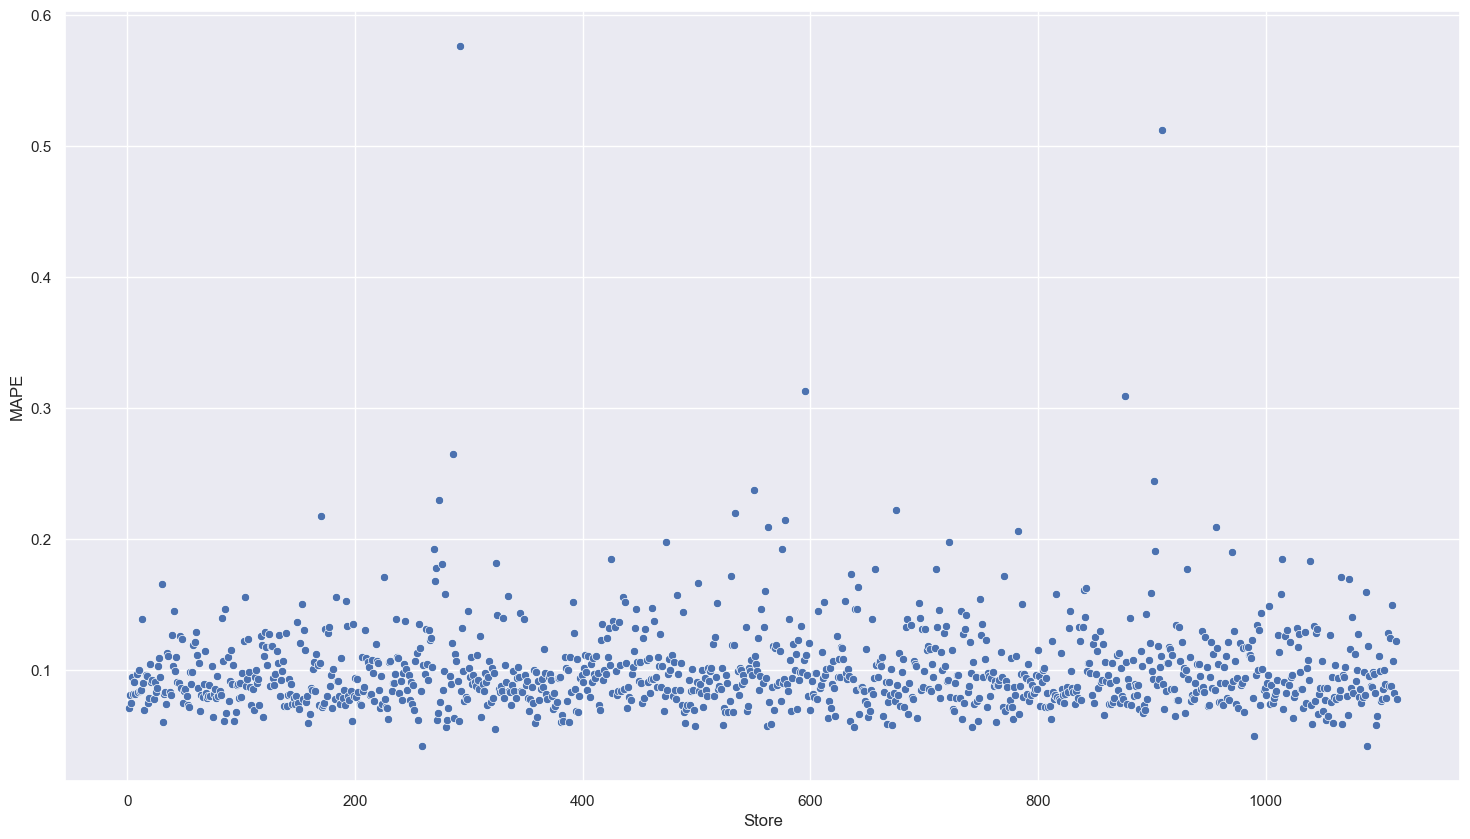

In [35]:
# Mostrando o erro médio percentual das lojas
plt.figure(figsize=(18, 10))
sns.scatterplot(
    x = 'Store', 
    y = 'MAPE', 
    data = df2
)

## Resultados Financeiros

In [36]:
# Mostrando a performance financeira geral do modelo (indica se a empresa consegue bater as metas totais de venda)
df3 = (
    df2[['Previsoes', 'PiorCenario', 'MelhorCenario']]
    .apply(
        lambda x: np.sum(x), 
        axis = 0
    )
    .reset_index()
    .rename(columns={'index': 'cenario', 0:'Valores'})
)
df3['Valores'] = df3['Valores'].map('R${:,.2f}'.format)
df3

,cenario,Valores
0,Previsoes,"R$283,763,968.00"
1,PiorCenario,"R$283,002,908.92"
2,MelhorCenario,"R$284,525,024.67"


## Performance da Modelagem

<Axes: xlabel='Previsoes', ylabel='Erro'>

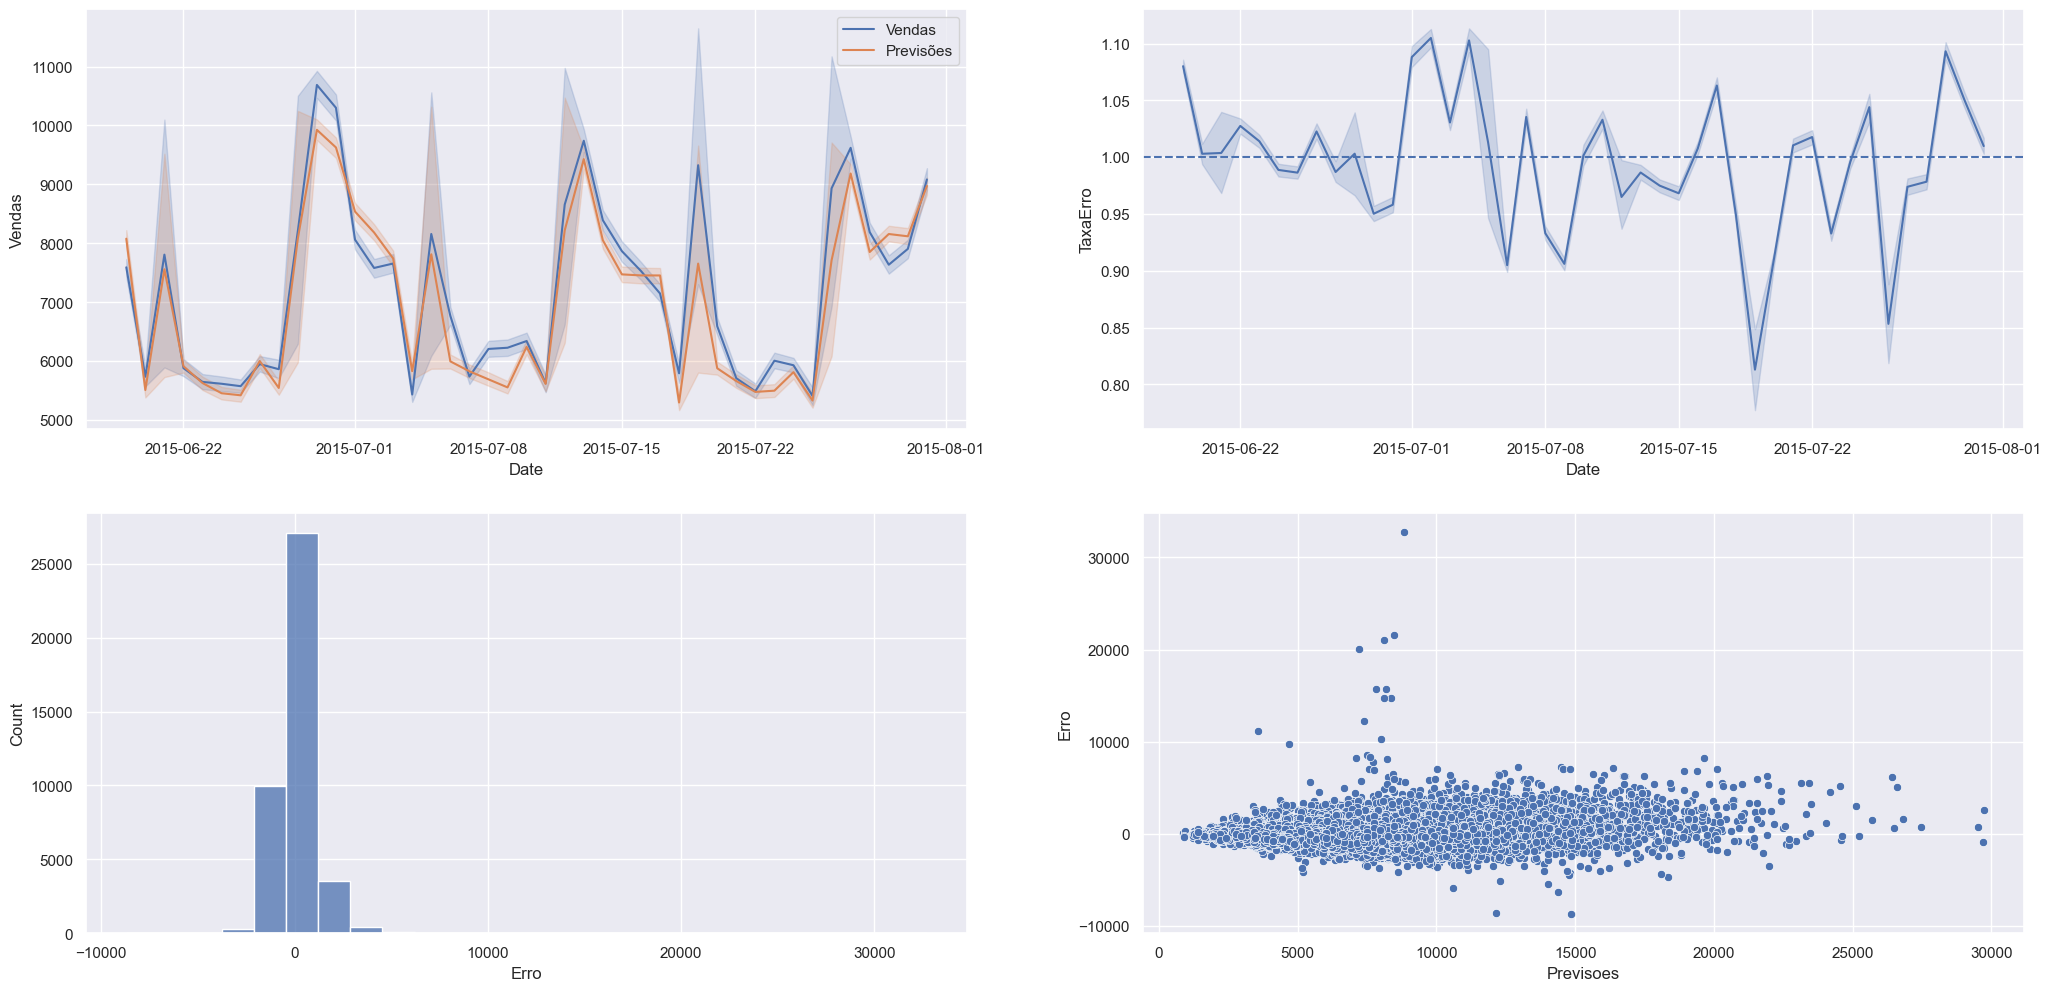

In [37]:
# Mostrando a performance da modelagem
df['Erro'] = df['Vendas'] - df['Previsoes']
df['TaxaErro'] = df['Previsoes']/df['Vendas']
df.loc[:, 'Date'] = X_test['Date'].copy()

# Gráfico de linha comparando as previsões com as Vendas reais ao longo do tempo
plt.subplot(2, 2, 1)
sns.lineplot(
    x='Date', 
    y='Vendas', 
    data=df, 
    label='Vendas'
)
sns.lineplot(
    x='Date', 
    y='Previsoes', 
    data=df, 
    label='Previsões'
)

# Taxa de Erro (quanto mais próximo de 1, menor o Erro)
# Valores superiores a 1: valores superestimados 
# Valores inferiores a 1: valores subestimados
plt.subplot(2, 2, 2)
sns.lineplot(
    x='Date', 
    y='TaxaErro', 
    data=df
)
plt.axhline(1, linestyle='--')

# Distribuição do Erro (deve ser próxima a normal)
plt.subplot(2, 2, 3)
sns.histplot(
    df['Erro'], 
    bins = 25, 
    kde = False
)

# Resíduos (deve ser próximo a um tubo imaginário)
plt.subplot(2, 2, 4)
sns.scatterplot(
    x = 'Previsoes', 
    y = 'Erro', 
    data = df
)

## Armazenamento do Modelo

In [ ]:
# Regressão Linear
pkl.dump(
    lr, 
    open(
        '../model/modeling/c01_lr_model.pkl', 
        'wb'
    )
)

In [ ]:
# Regressão Linear Lasso
pkl.dump(
    lrr, 
    open(
        '../model/modeling/c01_lrlasso_model.pkl', 
        'wb'
    )
)

In [ ]:
# Random Forest Regressor
pkl.dump(
    rf, 
    open(
        '../model/modeling/c01_rf_model.pkl', 
        'wb'
    )
)

In [ ]:

# XGBoost Regressor
pkl.dump(
    model_xgb, 
    open(
        '../model/modeling/c01_xgb_model.pkl', 
        'wb'
    )
)

In [ ]:
# XGBoost Regressor Final
pkl.dump(
    xgb_final, 
    open(
        '../model/modeling/c01_xgb_final.pkl', 
        'wb'
    )
)

# PRÓXIMOS PASSOS DO PROJETO

> **Completar o Ano de 2015:** </br>Identificar e coletar os meses faltantes de 2015 para garantir a integridade temporal dos dados, evitando viés na modelagem.

> **Engenharia de Features Avançada**</br>
> Explorar a criação de novas variáveis, além de interações entre variáveis relevantes para capturar padrões complexos.

> **Análise de Resultados do Modelo**</br>
> Coletar, consolidar e analisar os resultados práticos do modelo, utilizando métricas como MAE, RMSE e análise de resíduos para identificar padrões de erro.

> **Tratamento de Lojas com Alto Erro Percentual (>25%)**</br>
> Investigar causas de alto erro em lojas específicas, avaliando abordagens como segmentação de modelos, ajuste de hiperparâmetros, ou inclusão de variáveis contextuais (ex: localização, perfil de clientes).

> **Redução do Erro do Modelo**</br>
> Testar algoritmos alternativos e tratamento de outliers.

> **Monitoramento e Atualização Contínua**</br>
> Estabelecer rotinas de monitoramento do desempenho do modelo em produção e definir critérios para re-treinamento periódico com novos dados.

> **Documentação e Reprodutibilidade**</br>
> Documentar todas as etapas do pipeline de dados e modelagem, garantindo reprodutibilidade e facilitando futuras manutenções.